In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


## HELPER FUNCTIONS

In [2]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def eval_model(model, data_loader, loss_fn, accuracy_fn,
               device):

    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

## DATASET

In [3]:
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

class_names = train_data.classes

BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

img , img_label = train_data[0]

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## TRAINING/TESTING FUNCTION

In [5]:
def train_step(model , dataloader , loss_fn , optimizer , accuracy_fn , device):

    train_loss , train_acc = 0 , 0

    model.train()

    for batch , (X,y) in enumerate(dataloader):
        X , y = X.to(device) , y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred , y)

        train_loss += loss

        train_acc += accuracy_fn(y , y_pred.argmax(dim = 1))

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(dataloader)

    train_acc /= len(dataloader)

    print(f"Train Loss: {train_loss:.5f} | Train Acc : {train_acc:.2f}%")

def test_step(model , dataloader , loss_fn , accuracy_fn , device):

    test_loss , test_acc = 0 , 0

    model.eval()

    with torch.inference_mode():
        for X,y in dataloader:
            X , y = X.to(device) , y.to(device)

            test_pred = model(X)

            loss = loss_fn(test_pred , y)

            test_loss += loss 

            test_acc += accuracy_fn(y , test_pred.argmax(dim = 1))


        test_loss /= len(dataloader)

        test_acc /= len(dataloader)

        print(f"Test Loss: {test_loss:.5f} | Test Acc : {test_acc:.2f}%")


## BUILDING A CNN MODEL

In [6]:
class model_CNN(nn.Module):
    def __init__(self , input_shape , hidden_units , output_shape):
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape
                      , out_channels = hidden_units
                      , kernel_size = 3
                      , stride = 1
                      , padding = 1),
            nn.ReLU(),

            nn.Conv2d(in_channels = hidden_units
                      , out_channels = hidden_units
                      , kernel_size = 3
                      , stride = 1
                      , padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2 
                         ,stride = 2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units
                      , out_channels = hidden_units
                      , kernel_size = 3
                      , stride = 1
                      , padding = 1),
            nn.ReLU(),

            nn.Conv2d(in_channels = hidden_units
                      , out_channels = hidden_units
                      , kernel_size = 3
                      , stride = 1
                      , padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2
                        , stride = 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten() , 

            nn.Linear(in_features = hidden_units*7*7 , out_features = output_shape)
        )
    
    def forward(self , X):
        X = self.conv_block1(X)

        X = self.conv_block2(X)
        
        return self.classifier(X)

In [7]:
torch.manual_seed(42)

model = model_CNN(input_shape = 1 , hidden_units = 10 , output_shape = len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = model.parameters() , lr = 0.1)

In [10]:
# TRAINING LOOP

torch.manual_seed(42)
torch.cuda.manual_seed(42)
EPOCHS = 3

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch:{epoch+1}\n-------------------------")
    train_step(model , train_dataloader , loss_fn , optimizer , accuracy_fn , device)
    test_step(model , test_dataloader , loss_fn , accuracy_fn , device)

evaluation = eval_model(model , test_dataloader , loss_fn , accuracy_fn , device)
evaluation

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:1
-------------------------
Train Loss: 0.29430 | Train Acc : 89.33%
Test Loss: 0.31025 | Test Acc : 89.09%
Epoch:2
-------------------------
Train Loss: 0.28117 | Train Acc : 89.84%
Test Loss: 0.30470 | Test Acc : 88.59%
Epoch:3
-------------------------
Train Loss: 0.26973 | Train Acc : 90.11%
Test Loss: 0.28985 | Test Acc : 89.82%


{'model_name': 'model_CNN',
 'model_loss': 0.2898528277873993,
 'model_acc': 89.81629392971246}

In [11]:
def make_predictions(model , data , device):
    pred_probs = []

    model.to(device)
    model.eval()

    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample,dim = 0).to(device)

            logits_pred = model(sample)

            pred_prob = torch.softmax(logits_pred.squeeze() , dim = 0)

            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs) 

Accuracy: 100.0




(-0.5, 27.5, 27.5, -0.5)

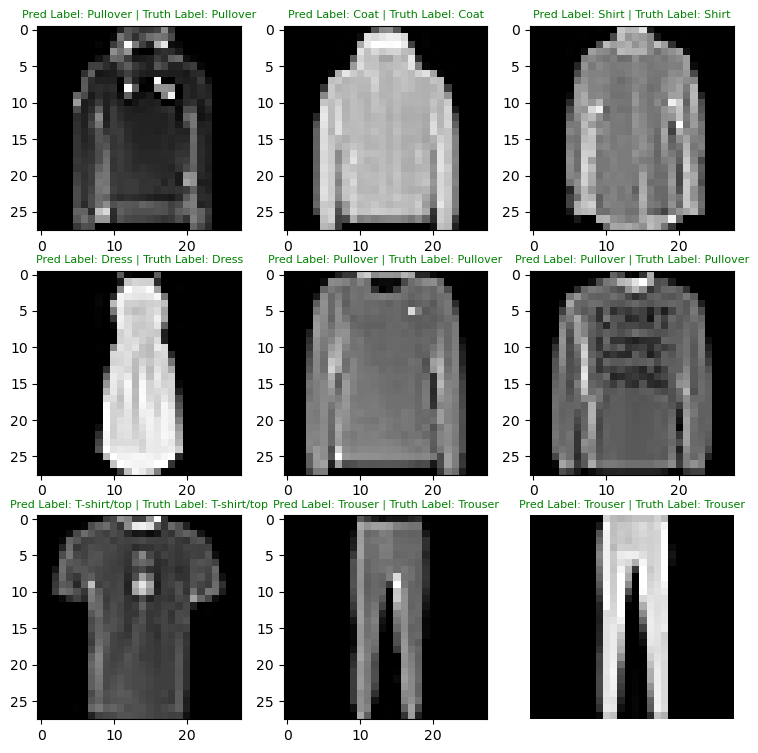

In [26]:
import random
# random.seed(42)

test_samples = []
test_labels = []

# PREDICTING LABELS
for sample, label in random.sample(list(test_data) , k=9):
    test_samples.append(sample)
    test_labels.append(label)
    
pred_probs = make_predictions(model ,test_samples , device)

pred_classes = pred_probs.argmax(dim = 1)
pred_classes

# ACCURACY
count = 0
for i in range(len(pred_classes)):
    count += 1 if pred_classes[i] == test_labels[i] else 0

print(f"Accuracy: {(count/len(pred_classes))*100}\n\n")

# PLOTTING PREDICTIONS
plt.figure(figsize = (9,9))

for i , sample in enumerate(test_samples):
    plt.subplot(3,3, i+1)

    plt.imshow(sample.squeeze() , cmap = "gray")

    pred_label = class_names[pred_classes[i]]
    
    true_label = class_names[test_labels[i]]

    title_next = f"Pred Label: {pred_label} | Truth Label: {true_label}"

    if pred_label == true_label:
        plt.title(title_next , fontsize = 8 , c = "g")
    else:
        plt.title(title_next , fontsize = 8 , c = "r")

plt.axis(False)